# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). The report must be self-contained, so please make sure that all relevant results are explicitly included in the report / notebook.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook or source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn. preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import cross_val_score
from skorch import NeuralNetRegressor
from numpy import mean
from numpy import std

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [77]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-02-12 11:15:57--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
正在解析主机 gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
正在连接 gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：3776 (3.7K) [text/plain]
正在保存至: “regression_dataset/train_data.csv.68”

train_data.csv.68   100%[===================>]   3.69K  --.-KB/s  用时 0s        

2022-02-12 11:15:57 (26.5 MB/s) - 已保存 “regression_dataset/train_data.csv.68” [3776/3776])

--2022-02-12 11:15:57--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
正在解析主机 gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
正在连接 gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：3788 (3.7K) [text/plain]
正在保存至: “regression_dataset/test_data.csv.68”

test_data.csv.68    100%[===================>]   3.70K  --.-KB/s  用时 0s        

2022-02-12 11:1

How to load the data:

In [78]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
train_df = train_df.sort_values('input')
x_train = train_df.iloc[:,0].values
y_train = train_df.iloc[:,1].values
#print("x_train: ",x_train)
#print("y_train: ",y_train)
print("x_train shape",x_train.shape)
print("y_train shape",y_train.shape)
x_train = np.reshape(x_train,(1, x_train.size))
print("x_train shape",x_train.shape)
y_train = np.reshape(y_train,(1, y_train.size))
print("y_train shape",y_train.shape)


x_train shape (100,)
y_train shape (100,)
x_train shape (1, 100)
y_train shape (1, 100)


How to get a specific sample:

In [79]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.915862840819678
LABEL: -3.742969516141261


All training points:

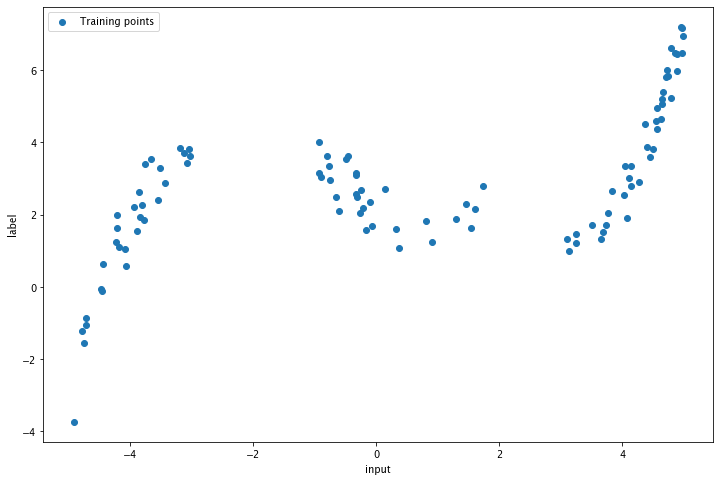

In [80]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()


##### Define Network
Define a fully connected feed-forward network with 2 hidden layers.Use a sigmoid activation function.

In [81]:

class Net(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No):
     
        super().__init__()
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x



##### Define dataset

In [82]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        data_len = len(lines)
        for i in range(1,data_len-1):
            sample = lines[i].split(',')
            try:
                self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)
            except ValueError :
                print("error on line",i)
                break


    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

##### Prepare for training 

In [83]:
##Make transformation
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [143]:

composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)
print('train:', len(train_dataset))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [70, 29])
print('train:', len(train_dataset), 'validation',len(val_dataset),'test:', len(test_dataset))


#load the data to use them
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = 4,shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,batch_size = len(val_dataset),shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = 10,shuffle = False) 


train: 99
train: 70 validation 29 test: 100


##### Define hyperparameters

In [144]:
torch.manual_seed(0)
# initialize network
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net_reg = Net(Ni, Nh1, Nh2, No)

# define the loss function
loss_fn = nn.MSELoss()
# define the optimizer
optimizer = optim.Adam(net_reg.parameters(), lr=0.002,weight_decay=1e-5)

# Check the divice
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_reg.to(device)

# Use Kfold to cross validate
k=5
cv=KFold(n_splits=k,shuffle=True,random_state=42)


#define number of epochs
num_epochs = 300
#define batch size
batch_size=16

Network initialized


##### Start training

In [145]:
### TRAINING LOOP
foldperf={}
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net_reg.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_loader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net_reg(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net_reg.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net_reg.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_loader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net_reg(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)
    

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 4.520579814910889
AVERAGE VAL LOSS: 4.200256824493408
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 2.6135125160217285
AVERAGE VAL LOSS: 3.170557737350464
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 2.439363718032837
AVERAGE VAL LOSS: 3.374340534210205
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 2.614701509475708
AVERAGE VAL LOSS: 3.502884864807129
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 2.619968891143799
AVERAGE VAL LOSS: 3.5050158500671387
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 2.6567227840423584
AVERAGE VAL LOSS: 3.399695873260498
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 2.4730615615844727
AVERAGE VAL LOSS: 3.136054277420044
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 2.559295654296875
AVERAGE VAL LOSS: 3.1975340843200684
#################
# EPOCH 8
#######

##### Plot loss

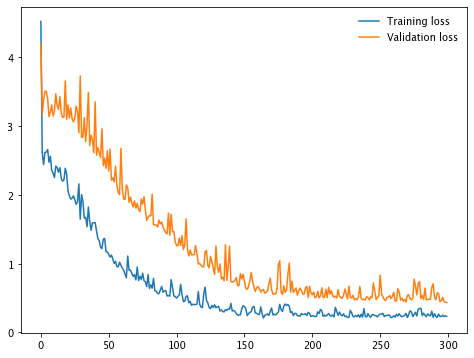

In [146]:

plt.figure(figsize=(8,6))
plt.plot(train_loss_log, label='Training loss')
plt.plot(val_loss_log, label='Validation loss')
plt.legend(frameon=False)

##### Start testing

In [ ]:
all_inputs = []
all_outputs = []
all_labels = []
test_loss= []
test_loss_log =[]
num_epochs=40
net_reg.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_loader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net_reg(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {np.mean(test_loss)}")

In [152]:
test_loss= []
test_loss_log =[]
num_epochs=40
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')
    net_reg.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in test_loader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net_reg(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            test_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(test_loss)
        print(f"AVERAGE TEST LOSS: {np.mean(test_loss)}")
        test_loss_log.append(test_loss)

#################
# EPOCH 0
#################
AVERAGE TEST LOSS: 0.2410515546798706
#################
# EPOCH 1
#################
AVERAGE TEST LOSS: 0.24105152487754822
#################
# EPOCH 2
#################
AVERAGE TEST LOSS: 0.2410515397787094
#################
# EPOCH 3
#################
AVERAGE TEST LOSS: 0.241051584482193
#################
# EPOCH 4
#################
AVERAGE TEST LOSS: 0.2410515397787094
#################
# EPOCH 5
#################
AVERAGE TEST LOSS: 0.2410515397787094
#################
# EPOCH 6
#################
AVERAGE TEST LOSS: 0.2410515993833542
#################
# EPOCH 7
#################
AVERAGE TEST LOSS: 0.241051584482193
#################
# EPOCH 8
#################
AVERAGE TEST LOSS: 0.2410515695810318
#################
# EPOCH 9
#################
AVERAGE TEST LOSS: 0.2410515546798706
#################
# EPOCH 10
#################
AVERAGE TEST LOSS: 0.241051584482193
#################
# EPOCH 11
#################
AVERAGE TEST LOSS: 0.241051539

In [148]:
'''
net = NeuralNetRegressor(Net
                         , max_epochs=100
                         , lr=0.001
                         , verbose=1)
X_trf = x_train.transpose()
y_trf = y_train.transpose()
print(X_trf.shape,y_trf.shape)
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_epochs': list(range(500,5500, 500))
}

gs = GridSearchCV(net, params, refit=False, scoring='r2', verbose=1, cv=cv)
gs.fit(X_trf, y_trf)
#best parameters set
print("Best parameters set found:")
print(gs.best_params_)


#score with best parameters
print("Score with best parameters:")
print(gs.best_score_)

print("All scores on the grid:")
pd.concat([pd.DataFrame(gs.cv_results_["params"]),pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["Scores"])],axis=1)
'''

'\nnet = NeuralNetRegressor(Net\n                         , max_epochs=100\n                         , lr=0.001\n                         , verbose=1)\nX_trf = x_train.transpose()\ny_trf = y_train.transpose()\nprint(X_trf.shape,y_trf.shape)\nfrom sklearn.model_selection import GridSearchCV\n\nparams = {\n    \'lr\': [0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3],\n    \'max_epochs\': list(range(500,5500, 500))\n}\n\ngs = GridSearchCV(net, params, refit=False, scoring=\'r2\', verbose=1, cv=cv)\ngs.fit(X_trf, y_trf)\n#best parameters set\nprint("Best parameters set found:")\nprint(gs.best_params_)\n\n\n#score with best parameters\nprint("Score with best parameters:")\nprint(gs.best_score_)\n\nprint("All scores on the grid:")\npd.concat([pd.DataFrame(gs.cv_results_["params"]),pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["Scores"])],axis=1)\n'

##### Grid search

In [149]:
train_dataset = CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)
all_train_inputs = []
all_train_labels = []
 # Disable gradient tracking
#with torch.no_grad():
for sample_batched in train_dataset:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Save outputs and labels
    all_train_inputs.append(x_batch)
    all_train_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_train_inputs  = torch.cat(all_train_inputs)
all_train_labels  = torch.cat(all_train_labels)

In [150]:
print(all_train_inputs)
print(all_train_labels)
print(all_train_inputs.shape)
print(all_train_labels.shape)

tensor([-4.7879, -3.5091, -3.8554, -4.0835, -4.2306, -4.4520, -3.6641, -4.2091,
        -4.4369, -3.4402, -3.8018, -4.7541, -4.2209, -3.0500, -4.0648, -4.7197,
        -4.9159, -3.5440, -3.7688, -3.1945, -3.7547, -4.4798, -3.8890, -4.1900,
        -4.7165, -3.8445, -3.9470, -3.1229, -3.0822, -3.0311, -0.7690, -0.9029,
        -0.7543, -0.3092, -0.8026, -0.1705, -0.6539, -0.4860, -0.3388, -0.0664,
        -0.9331, -0.2531, -0.6097, -0.4642, -0.9396, -0.1086, -0.2221, -0.3299,
        -0.2649, -0.3363,  0.3635,  1.7260,  0.9029,  1.2995,  0.3187,  0.8120,
         1.5977,  1.4583,  0.1418,  1.5394,  3.4972,  3.7669,  3.6798,  3.1303,
         3.6587,  3.2453,  3.2455,  3.8380,  3.1055,  3.7264,  4.9457,  4.7217,
         4.1439,  4.7931,  4.7090,  4.9725,  4.9775,  4.5000,  4.6557,  4.2688,
         4.6325,  4.8520,  4.5690,  4.0234,  4.5546,  4.3686,  4.9603,  4.3912,
         4.0381,  4.8921,  4.1439,  4.6386,  4.1000,  4.8907,  4.0668,  4.7459,
         4.4545,  4.5472,  4.6496])
tens

In [153]:
from sklearn.model_selection import GridSearchCV


#train_df = pd.read_csv('regression_dataset/train_data.csv')
#train_df = train_df.sort_values('input')
#X_trf = #train_df.iloc[:,0].values
#y_trf = train_df.iloc[:,1].values
#X_trf = np.array([X_trf]).transpose()
#print(X_trf.shape)
#print(y_trf.shape)
#print(X_trf)
#y_trf = np.array(y_trf)
#print(y_trf)

#all_train_labels = all_train_labels.reshape(-1,1)
'''class MyNet(NeuralNetRegressor):
    def fit(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        return super().fit(X, y)'''

net = NeuralNetRegressor(
    Net(Ni,Nh1,Nh2,No),
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(all_train_inputs, all_train_labels)
#y_proba = net.predict_proba(x_train)

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20]#,
    #'module__num_units': [10, 20]
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2,error_score='raise')

gs.fit(all_train_inputs, all_train_labels)#X_trf, y_trf)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Network initialized


ValueError: The target data shouldn't be 1-dimensional but instead have 2 dimensions, with the second dimension having the same size as the number of regression targets (usually 1). Please reshape your target data to be 2-dimensional (e.g. y = y.reshape(-1, 1).

##### Network output


In [ ]:
# Input vector
x_vec = torch.linspace(train_df.input.min(),train_df.input.max(),1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
net_reg.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net_reg(x_vec) # y_predicted
print(f"Output shape: {y_vec.shape}")



Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


1000
100


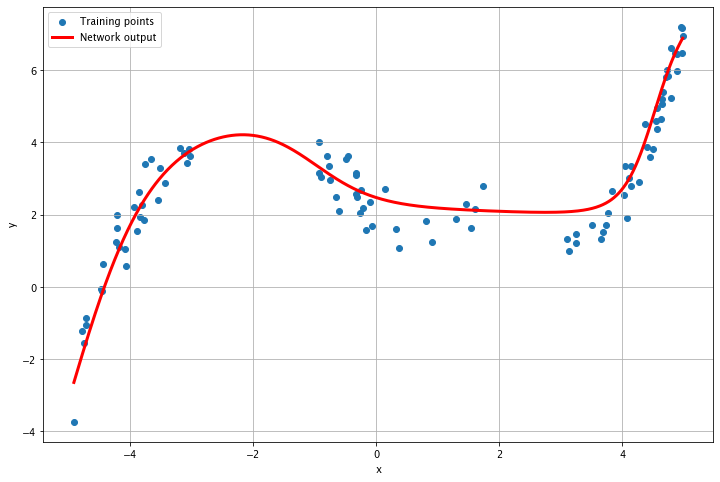

In [ ]:


#import plotly.graph_objects as go
#fig.add_trace(go.Scatter(x=c.flatten().numpy(), y=d.flatten().detach().numpy(), mode="lines"))
#fig.show()

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec2 = x_vec.squeeze().cpu().numpy()
y_vec2 = y_vec.squeeze().cpu().numpy()
#print(x_vec)
# Plot output
plt.figure(figsize=(12,8))


train_df_input = train_df.input.to_list()
print(len(y_vec2))
print(len(train_df_input))
#plt.plot(train_df.input, train_df.label, label='Network output')
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.plot(x_vec2, y_vec2,label='Network output', color='red', linewidth=3)
#plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()



#### Access network parameters

In [ ]:
# First hidden layer
h1_w = net_reg.fc1.weight.data.cpu().numpy()
h1_b = net_reg.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net_reg.fc2.weight.data.cpu().numpy()
h2_b = net_reg.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net_reg.out.weight.data.cpu().numpy()
out_b = net_reg.out.bias.data.cpu().numpy()

#### Weights histogram

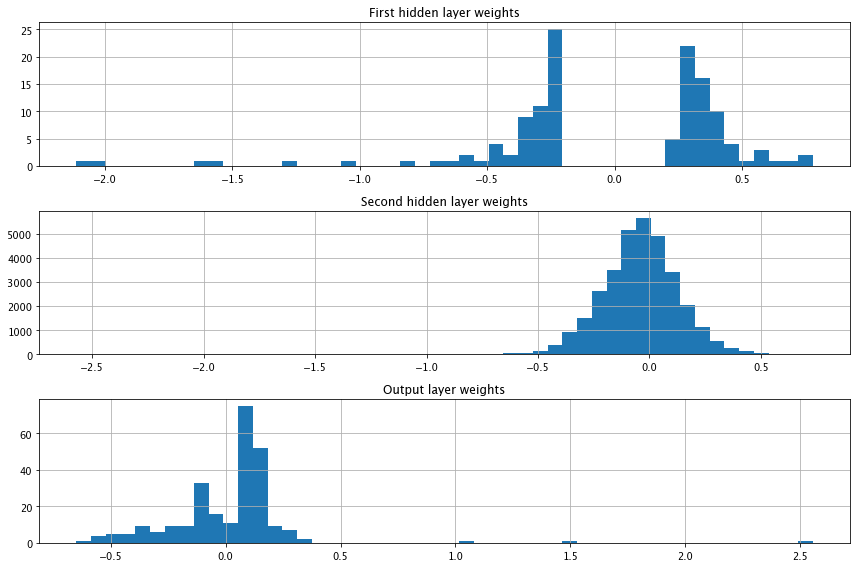

In [ ]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

#### Save network parameters

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net_reg.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])


#### Save optimizer state

In [ ]:
### Save the optimizer state
torch.save(optimizer.state_dict(), 'optimizer_state.torch')

### Reload the optimizer state
optimizer = optim.Adam(net_reg.parameters(), lr=0.001)
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)

#### Load network

In [ ]:
### Reload the network state
# First initialize the network (if not already done)
# IMPORTANT: you need to know the model definition!!
net = Net(Ni, Nh1, Nh2, No) 
# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

#### Analyze activations

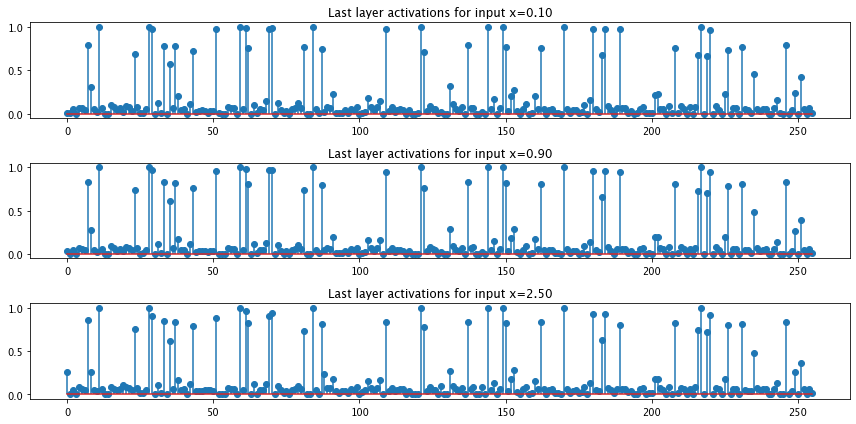

In [ ]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [157]:
import torch
from pathlib import Path
import pandas as pd
import numpy as np
import random
import torchvision
import matplotlib.pyplot as plt
import torchvision.datasets as dsts
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

import torch.nn.functional as F
import torch.nn as NN
torch.__version__



'1.10.2'

In order to use dataloader from pyTorch, we need to build a dataset

In [158]:
# class FashionMNISTDataset(Dataset):
#     def __init__(self, csv_file, transform=None):
#         data = pd.read_csv(csv_file)
#         self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28).astype(float)
#         self.Y = np.array(data.iloc[:, 0]);
#         del data;  #结束data对数据的引用,节省空间
#         self.len=len(self.X)

#     def __len__(self):
#         return self.len
#         #return len(self.X)


#     def __getitem__(self, idx):
#         item = self.X[idx]
#         label = self.Y[idx]
#         return (item, label)

Download the dataset:

In [159]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)
'''

kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 

for train_index, test_index in kf.split(X):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = X[train_index], X[test_index] 
      y_train, y_test = y[train_index], y[test_index]
      '''

'\n\nkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) \n\nfor train_index, test_index in kf.split(X):\n      print("Train:", train_index, "Validation:",test_index)\n      X_train, X_test = X[train_index], X[test_index] \n      y_train, y_test = y[train_index], y[test_index]\n      '

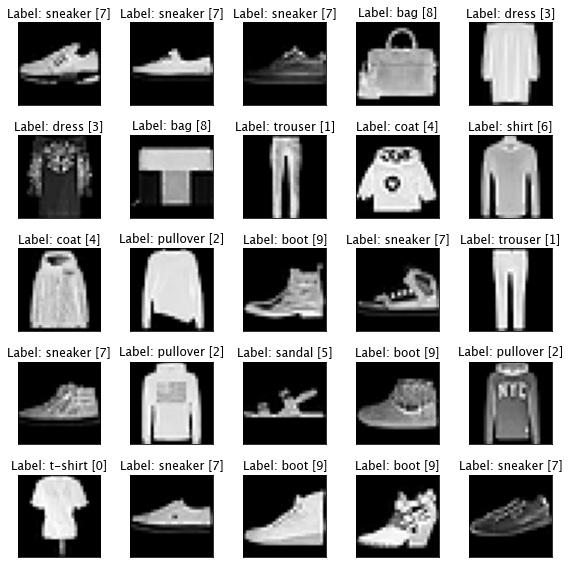

In [160]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

How to get an image and the corresponding label:

SAMPLE AT INDEX 1
LABEL: 0


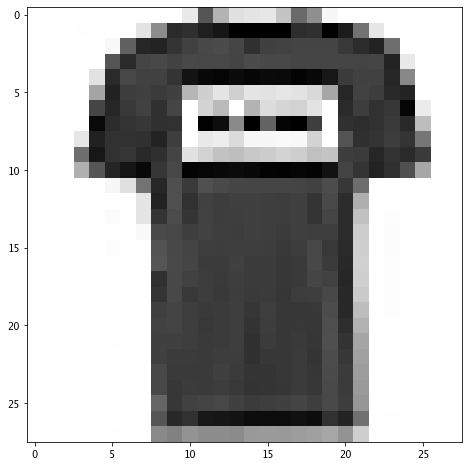

In [161]:
sample_index = 1
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [162]:

image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [163]:

to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


目标：
implement classification tasks and explore advanced optimizers and regularization methods
*	1 pt: optimize hyperparameters using grid/random search and cross-validation 
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields

#### Define the dataset transform

In [164]:

train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

#### Define the dataloader

train: 60000 test: 10000
train: 50000 validation 10000 test: 10000


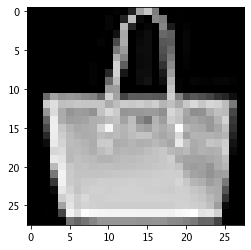

In [165]:
print('train:', len(train_dataset), 'test:', len(test_dataset))
# 首先先查看train和test数据集的数量，看看是否满足预订的分配目标

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

print('train:', len(train_dataset), 'validation',len(val_dataset),'test:', len(test_dataset))

#define a batch size as 256
BATCH_SIZE = 256

#load the data to use them
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,batch_size = BATCH_SIZE,shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size = BATCH_SIZE,shuffle = False) 
# needn't shuffle for test data



#have a look on the data
a = iter(train_loader)
data = next(a)

img = data[0][0].reshape(28,28)
data[0][0].shape,img.shape
(torch.Size([1, 28, 28]), torch.Size([28, 28]))
plt.imshow(img,cmap = plt.cm.gray)
plt.show()


#### Implement classification task using neural networks
##### Define network model

In [166]:
import torch.nn.functional as F

In [167]:

'''
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x'''

'\nclass Net(nn.Module):\n    \n    def __init__(self, Ni, Nh1, Nh2, No):\n        """\n        Ni - Input size\n        Nh1 - Neurons in the 1st hidden layer\n        Nh2 - Neurons in the 2nd hidden layer\n        No - Output size\n        """\n        super().__init__()\n        \n        print(\'Network initialized\')\n        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)\n        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)\n        self.out = nn.Linear(in_features=Nh2, out_features=No)\n        self.act = nn.Sigmoid()\n        \n    def forward(self, x, additional_out=False):\n        x = self.act(self.fc1(x))\n        x = self.act(self.fc2(x))\n        x = self.out(x)\n        return x'

In [168]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(128, 64)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(64, 10)
        self.dropout2 = nn.Dropout(p=0.1) 
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

##### Prepare for training

In [169]:
# Initialize the network
torch.manual_seed(0)

net = Net()
net.to(device)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss() 

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 50

##### Start training and validating

In [170]:
### TRAINING LOOP

train_loss_log = []
val_loss_log = []

for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_loader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        # Forward pass
        out = net(x_batch)

        # Compute loss
        loss = loss_fn(out, label_batch)

        # Backpropagation
        net.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_loader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            out = net(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)

        # Save average validation loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)
    

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.7471526265144348
AVERAGE VAL LOSS: 0.48731112480163574
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.4476972222328186
AVERAGE VAL LOSS: 0.4548317492008209
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.3946368992328644
AVERAGE VAL LOSS: 0.40558940172195435
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.36261796951293945
AVERAGE VAL LOSS: 0.38812485337257385
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.3399156928062439
AVERAGE VAL LOSS: 0.3680431544780731
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.32942089438438416
AVERAGE VAL LOSS: 0.3488501310348511
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.30717217922210693
AVERAGE VAL LOSS: 0.3691156506538391
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.29262322187423706
AVERAGE VAL LOSS: 0.3367256224155426
#################

##### Plot train and validation losses

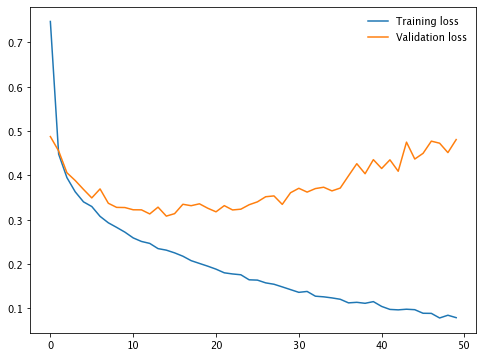

In [171]:
# Plot losses
plt.figure(figsize=(8,6))
#plt.semilogy(train_loss_log, label='Train loss')
#plt.semilogy(val_loss_log, label='Validation loss')
#plt.xlabel('Epoch')
#plt.ylabel('Loss')
#plt.grid()
#plt.legend()
#plt.show()
plt.plot(train_loss_log, label='Training loss')
plt.plot(val_loss_log, label='Validation loss')
plt.legend(frameon=False)

##### Start testing

In [172]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_loader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.5186982154846191


##### Accuracy of model

In [173]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = net(images)
        # 统计预测概率最大的下标
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 89.12 %


##### Weights histogram

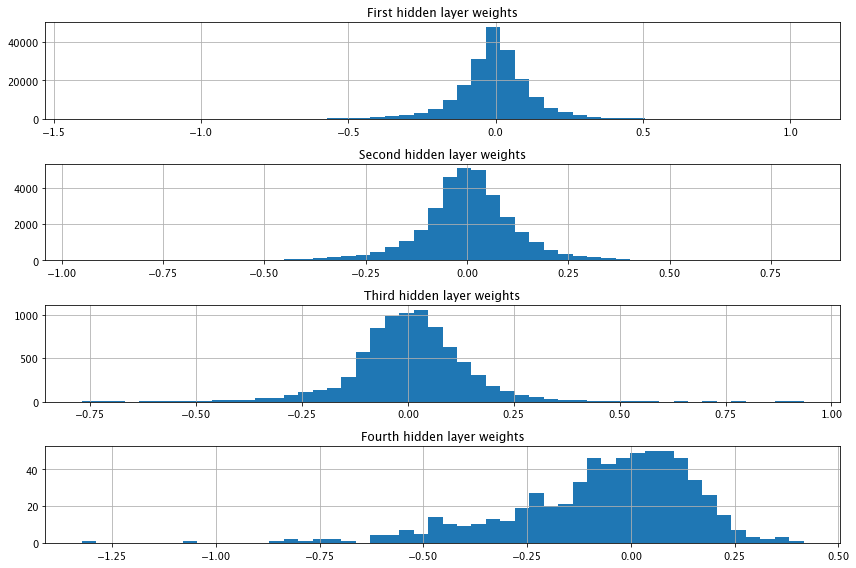

In [174]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Third hidden layer
h3_w = net.fc3.weight.data.cpu().numpy()
h3_b = net.fc3.bias.data.cpu().numpy()

# Fourth hidden layer
h4_w = net.fc4.weight.data.cpu().numpy()
h4_b = net.fc4.bias.data.cpu().numpy()


# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('Third hidden layer weights')
axs[3].hist(h4_w.flatten(), 50)
axs[3].set_title('Fourth hidden layer weights')


[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()


##### Analyze activations

In [175]:
'''
# First naive way: simply change the network definition to return an additional output

# More advanced strategy: using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()
'''

"\n# First naive way: simply change the network definition to return an additional output\n\n# More advanced strategy: using hooks\n\ndef get_activation(layer, input, output):\n    global activation\n    activation = torch.sigmoid(output)\n\n### Register hook  \nhook_handle = net.fc2.register_forward_hook(get_activation)\n\n### Analyze activations\nnet = net.to(device)\nnet.eval()\nwith torch.no_grad():\n    x1 = torch.tensor([0.1]).float().to(device)\n    y1 = net(x1)\n    z1 = activation\n    x2 = torch.tensor([0.9]).float().to(device)\n    y2 = net(x2)\n    z2 = activation\n    x3 = torch.tensor([2.5]).float().to(device)\n    y3 = net(x3)\n    z3 = activation\n\n### Remove hook\nhook_handle.remove()\n\n### Plot activations\nfig, axs = plt.subplots(3, 1, figsize=(12,6))\naxs[0].stem(z1.cpu().numpy(), use_line_collection=True)\naxs[0].set_title('Last layer activations for input x=%.2f' % x1)\naxs[1].stem(z2.cpu().numpy(), use_line_collection=True)\naxs[1].set_title('Last layer activat

##### Hyperparameter optimization using grid search

In [176]:
'''
#train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
#print(train_dataset)
X_trf = train_dataset.iloc[:,0].values
#y_trf = train_dataset.iloc[:,1].values
X_trf = np.array([X_trf]).transpose()
print(X_trf)
y_trf = np.array(y_trf)
print(y_trf)
print(X_trf.shape)
print(y_trf.shape)
'''

"\n#train_dataset = CsvDataset('train_data.csv', transform=composed_transform)\n#print(train_dataset)\nX_trf = train_dataset.iloc[:,0].values\n#y_trf = train_dataset.iloc[:,1].values\nX_trf = np.array([X_trf]).transpose()\nprint(X_trf)\ny_trf = np.array(y_trf)\nprint(y_trf)\nprint(X_trf.shape)\nprint(y_trf.shape)\n"

In [177]:
all_train_inputs = []
all_train_labels = []
 # Disable gradient tracking
with torch.no_grad():
    for sample_batched in train_loader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Save outputs and labels
        all_train_inputs.append(x_batch)
        all_train_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_train_inputs  = torch.cat(all_train_inputs)
all_train_labels  = torch.cat(all_train_labels)


In [178]:
print(all_train_inputs.shape)
print(all_train_labels.shape)
print(all_train_inputs)
print(all_train_labels)

torch.Size([50000, 1, 28, 28])
torch.Size([50000])
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1255, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1373, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3804, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1020, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.00

In [179]:
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    Net(),
    max_epochs=10,
    lr=0.01,
    iterator_train__shuffle=True,    
)

net.fit(all_train_inputs, all_train_labels)

net.set_params(train_split=False, verbose=0)
params = {
    'lr': [0.001, 0.01, 0.02],
    'max_epochs': [10, 20, 30]#,
    #'optimizer': ['SGD', 'Adagrad',  'Adam', 'Adamax', 'Nadam']
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2,error_score='raise')

gs.fit(all_train_inputs, all_train_labels)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1           nan       0.0470           nan  2.0227
      2           nan       0.0021           nan  2.0164
      3           nan       0.0368           nan  2.0862
      4           nan       0.0998           nan  1.9652
      5           nan       0.0998           nan  1.9853
      6           nan       0.0998           nan  1.7520
      7           nan       0.0998           nan  1.7926
      8           nan       0.0998           nan  1.8468
      9           nan       0.0998           nan  1.7975
     10           nan       0.0998           nan  1.7540
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ............................lr=0.001, max_epochs=10; total time=  13.8s
[CV] END ............................lr=0.001, max_epochs=10; total time=  16.8s
[CV] END ............................lr=0.001, max_epochs=10; total time=  15.0s
[CV] END ....

In [180]:

#from skorch import NeuralNetClassifier

#net_classifier = NeuralNetClassifier(
#    Net(),
#    max_epochs=10,
#    lr=0.01,
#    iterator_train__shuffle=True,    
#    )

#net_classifier.fit(X_trf, y_trf)

In [181]:
'''
from sklearn.model_selection import GridSearchCV
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'optimizer': ['SGD', 'Adagrad',  'Adam', 'Adamax', 'Nadam'],
    'dropout_rate': [0.1,  0.3, 0.5,  0.7, 0.9],
}
gs = GridSearchCV(net_classifier, params, refit=False, cv=3, scoring='neg_root_mean_squared_error')
# cv specifies the number of folds in a (Stratified)KFold

gs.fit(X_trf.cpu(), y_trf.cpu())
print(gs.best_score_, gs.best_params_)
'''

"\nfrom sklearn.model_selection import GridSearchCV\nparams = {\n    'lr': [0.01, 0.02],\n    'max_epochs': [10, 20],\n    'optimizer': ['SGD', 'Adagrad',  'Adam', 'Adamax', 'Nadam'],\n    'dropout_rate': [0.1,  0.3, 0.5,  0.7, 0.9],\n}\ngs = GridSearchCV(net_classifier, params, refit=False, cv=3, scoring='neg_root_mean_squared_error')\n# cv specifies the number of folds in a (Stratified)KFold\n\ngs.fit(X_trf.cpu(), y_trf.cpu())\nprint(gs.best_score_, gs.best_params_)\n"

####  Build CNN Neural Networks

In [182]:
class CNN(NN.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = NN.Sequential(   
            NN.Conv2d(1, 16, kernel_size=5, padding=2),
            NN.BatchNorm2d(16), 
            NN.ReLU()) #16, 28, 28
        self.pool1=NN.MaxPool2d(2) #16, 14, 14
        self.layer2 = NN.Sequential(
            NN.Conv2d(16, 32, kernel_size=3),
            NN.BatchNorm2d(32),
            NN.ReLU())#32, 12, 12
        self.layer3 = NN.Sequential(
            NN.Conv2d(32, 64, kernel_size=3),
            NN.BatchNorm2d(64),
            NN.ReLU()) #64, 10, 10
        self.pool2=NN.MaxPool2d(2)  #64, 5, 5
        self.fc = NN.Linear(5*5*64, 10)
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out=self.pool1(out)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out=self.layer3(out)
        #print(out.shape)
        out=self.pool2(out)
        #print(out.shape)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        return out




In [183]:

cnn = CNN()
#可以通过以下方式验证，没报错说明没问题，
cnn(torch.rand(1,1,28,28))

tensor([[ 0.5736,  0.0525, -0.6721, -0.5315,  0.8835, -1.1264, -0.8299,  1.1308,
         -0.2019,  0.8239]], grad_fn=<AddmmBackward0>)

In [184]:
print(cnn)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1600, out_features=10, bias=True)
)


In [185]:
DEVICE=torch.device("cpu")
if torch.cuda.is_available():
        DEVICE=torch.device("cuda")
print(DEVICE)

cpu


In [186]:
cnn=cnn.to(DEVICE)

## Loss Function


In [187]:
criterion = NN.CrossEntropyLoss().to(DEVICE)

## Optimizer

In [188]:
LEARNING_RATE=0.01
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

## Training

In [189]:
TOTAL_EPOCHS=50
losses = []
for epoch in range(TOTAL_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.float().to(DEVICE)
        labels = labels.to(DEVICE)
        #清零
        optimizer.zero_grad()
        outputs = cnn(images)
        #计算损失函数
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.item());
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'%(epoch+1, TOTAL_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.data.item()))


Epoch : 1/50, Iter : 100/195,  Loss: 0.4200
Epoch : 2/50, Iter : 100/195,  Loss: 0.3054
Epoch : 3/50, Iter : 100/195,  Loss: 0.2352
Epoch : 4/50, Iter : 100/195,  Loss: 0.2431
Epoch : 5/50, Iter : 100/195,  Loss: 0.2015
Epoch : 6/50, Iter : 100/195,  Loss: 0.2572
Epoch : 7/50, Iter : 100/195,  Loss: 0.1971
Epoch : 8/50, Iter : 100/195,  Loss: 0.1172
Epoch : 9/50, Iter : 100/195,  Loss: 0.1655
Epoch : 10/50, Iter : 100/195,  Loss: 0.1447
Epoch : 11/50, Iter : 100/195,  Loss: 0.2141
Epoch : 12/50, Iter : 100/195,  Loss: 0.1016
Epoch : 13/50, Iter : 100/195,  Loss: 0.1234
Epoch : 14/50, Iter : 100/195,  Loss: 0.1614
Epoch : 15/50, Iter : 100/195,  Loss: 0.1669
Epoch : 16/50, Iter : 100/195,  Loss: 0.0879
Epoch : 17/50, Iter : 100/195,  Loss: 0.0985
Epoch : 18/50, Iter : 100/195,  Loss: 0.1871
Epoch : 19/50, Iter : 100/195,  Loss: 0.0881
Epoch : 20/50, Iter : 100/195,  Loss: 0.1222
Epoch : 21/50, Iter : 100/195,  Loss: 0.0969
Epoch : 22/50, Iter : 100/195,  Loss: 0.0778
Epoch : 23/50, Iter

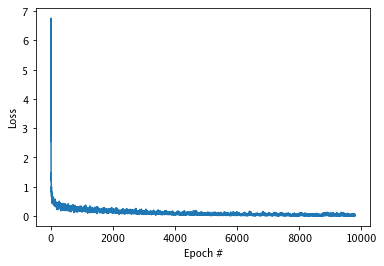

In [190]:
#plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses);
plt.show();

In [191]:
torch.save(cnn.state_dict(), "fm-cnn3.pth")
# 加载用
#cnn.load_state_dict(torch.load("fm-cnn3.pth"))

### Validation accuracy


In [192]:
cnn.eval()
correct = 0
total = 0
for images, labels in val_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('accuracy: %.4f %%' % (100 * correct / total))

accuracy: 90.6000 %


### Test accuracy

In [193]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(DEVICE)
    outputs = cnn(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('accuracy: %.4f %%' % (100 * correct / total))

accuracy: 90.6100 %
